

Mount Google Drive


In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
pwd


'/content'

Set the working directory

In [15]:
WORKING_PATH = '/content/drive/MyDrive/NLP practicas/Project'

In [16]:
%cd {WORKING_PATH}

[Errno 2] No such file or directory: '/content/drive/MyDrive/NLP practicas/Project'
/content


In [17]:
ls

Automotive_5.json  drive/  sample_data/


## Data Loading

In [18]:
import json

def load_amazon_reviews(path, sample_size=None):

  data = []
  bad = 0

  with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
      try:
        review = json.loads(line)
      except json.JSONDecodeError:
          bad += 1
          continue

      data.append({
      "review": review["reviewText"],
      "rating": review["overall"]
      })

      if sample_size and i + 1 >= sample_size:
        break
    print("Bad lines:", bad)
    return data

In [19]:
reviews = load_amazon_reviews("Automotive_5.json", sample_size=20000)
print("Number of reviews:", len(reviews))
print("Primera review:")
print(reviews[0])


Bad lines: 0
Number of reviews: 20000
Primera review:
{'review': "I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though.", 'rating': 5.0}


In [20]:
import pandas as pd
df = pd.DataFrame(reviews)


In [21]:
df.dropna(subset=['review', 'rating'], inplace=True)  #quitar valores nulos
df.reset_index(drop=True, inplace=True)  #resetear indice

# Exploratory Data Analysis

In [22]:
df.head()

,review,rating
0,I needed a set of jumper cables for my new car...,5.0
1,"These long cables work fine for my truck, but ...",4.0
2,Can't comment much on these since they have no...,5.0
3,I absolutley love Amazon!!! For the price of ...,5.0
4,I purchased the 12' feet long cable set and th...,5.0


For an initial exploration of the data, tokenization is performed using a simple split approach.

In [23]:
splitted_reviews = df['review'].str.lower().str.split()   #convertir en minuscula y tokenizar con split

In [24]:
print(splitted_reviews.head())

0    [i, needed, a, set, of, jumper, cables, for, m...
1    [these, long, cables, work, fine, for, my, tru...
2    [can't, comment, much, on, these, since, they,...
3    [i, absolutley, love, amazon!!!, for, the, pri...
4    [i, purchased, the, 12', feet, long, cable, se...
Name: review, dtype: object


The result stored in splitted_reviews is a Series in which each row contains a list of words.

In [25]:
step1 = splitted_reviews.apply(pd.Series)
step1.head()

,0,1,2,3,4,5,6,7,8,9,...,2229,2230,2231,2232,2233,2234,2235,2236,2237,2238
0,i,needed,a,set,of,jumper,cables,for,my,new,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,these,long,cables,work,fine,for,my,"truck,",but,the,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,can't,comment,much,on,these,since,they,have,not,yet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,i,absolutley,love,amazon!!!,for,the,price,of,a,set,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,i,purchased,the,12',feet,long,cable,set,and,they,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
step2 = step1.stack()
step2.head()

0  0         i
   1    needed
   2         a
   3       set
   4        of
dtype: object

In [27]:
step3 = step2.reset_index(drop=True)
step3.head(10)

,0
0,i
1,needed
2,a
3,set
4,of
5,jumper
6,cables
7,for
8,my
9,new


In [28]:
words = step3.rename("word")
words.head()

,word
0,i
1,needed
2,a
3,set
4,of


Distribution of Reviews by Sentiment

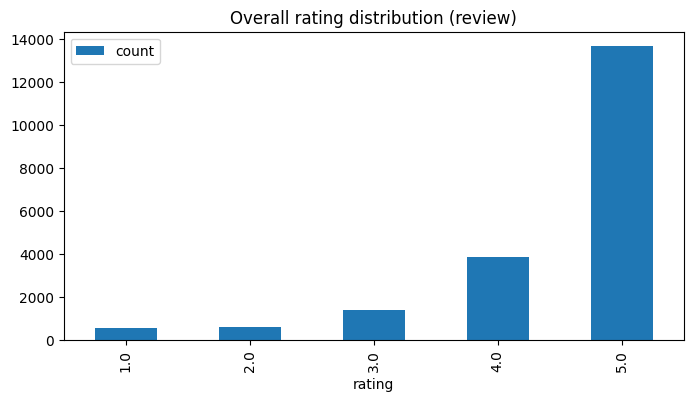

In [29]:
aux_df = pd.DataFrame(df['rating'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall rating distribution (review)', figsize=(8, 4))

In [30]:
(df['rating'].value_counts(normalize=True)).round(4)

,proportion
rating,
5.0,0.6832
4.0,0.1926
3.0,0.0684
2.0,0.0292
1.0,0.0266


In [31]:
def label_sentiment(row):
    if int(row['rating']) <= 3:
        return 0
    else:
        return 1

In [32]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [33]:
df.head()

,review,rating,sentiment_label
0,I needed a set of jumper cables for my new car...,5.0,1
1,"These long cables work fine for my truck, but ...",4.0,1
2,Can't comment much on these since they have no...,5.0,1
3,I absolutley love Amazon!!! For the price of ...,5.0,1
4,I purchased the 12' feet long cable set and th...,5.0,1


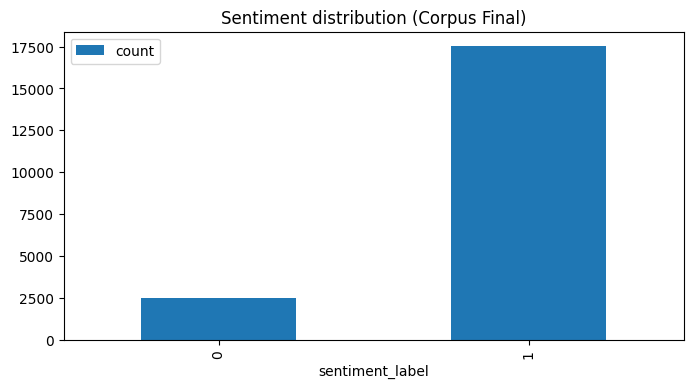

In [34]:
aux_df = pd.DataFrame(df['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [35]:
df['sentiment_label'].value_counts(normalize=True)

,proportion
sentiment_label,
1,0.8757
0,0.1243


It can be observed that the dataset is imbalanced. This suggests the use of class weighting, which penalizes errors in the minority class more heavily.

## Word Cloud

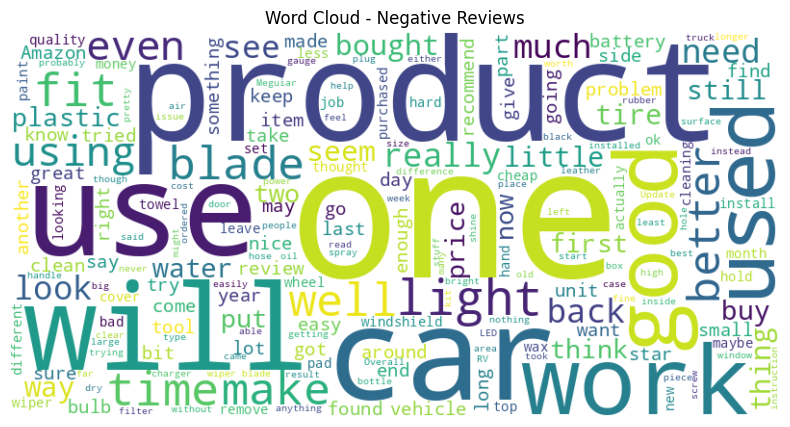

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_text = " ".join(df[df["sentiment_label"] == 0]["review"])

wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()

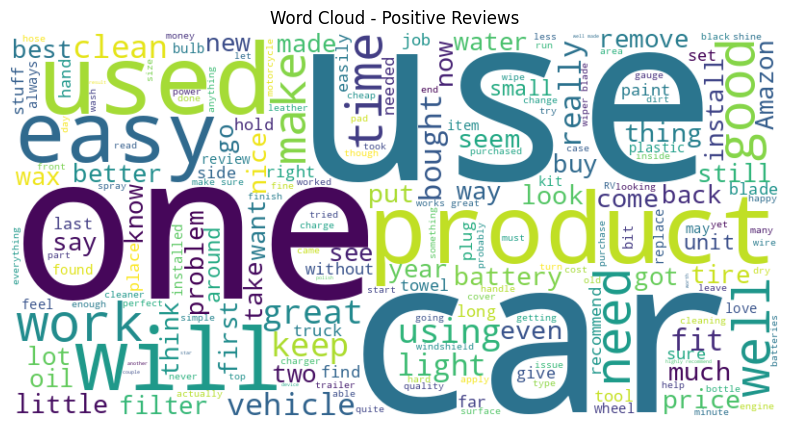

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_text = " ".join(df[df["sentiment_label"] == 1]["review"])

wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")
plt.show()

The word clouds show that both positive and negative reviews share frequent neutral terms such as “use”, “product”, and “one”, reflecting the product-focused nature of the corpus.

However, positive reviews contain clearer evaluative words such as “great”, “well”, and “easy”, indicating satisfaction and usability. In contrast, negative reviews include terms related to problems and performance issues, suggesting dissatisfaction with functionality rather than strong emotional language.

Overall, the visualization highlights that sentiment differences rely more on evaluative adjectives than on general product-related vocabulary.

## Word2Vec + Visualización 2D

In [38]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 65.9 MB/s eta 0:00:00


In [39]:
tokenized_reviews = df["review"].str.lower().str.split().tolist()  #simple tokenization just for exploration

In [40]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

In [41]:
words_to_explore = ["good", "bad", "movie", "boring"]

In [42]:
similar_words = []

for word in words_to_explore:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=10)
        similar_words.append(word)
        similar_words.extend([w[0] for w in similar])

In [43]:
similar_words = list(set(similar_words))   #Drop duplicates

In [44]:
from sklearn.decomposition import PCA
import numpy as np

word_vectors = np.array([w2v_model.wv[word] for word in similar_words])

pca = PCA(n_components=2)
reduced = pca.fit_transform(word_vectors)

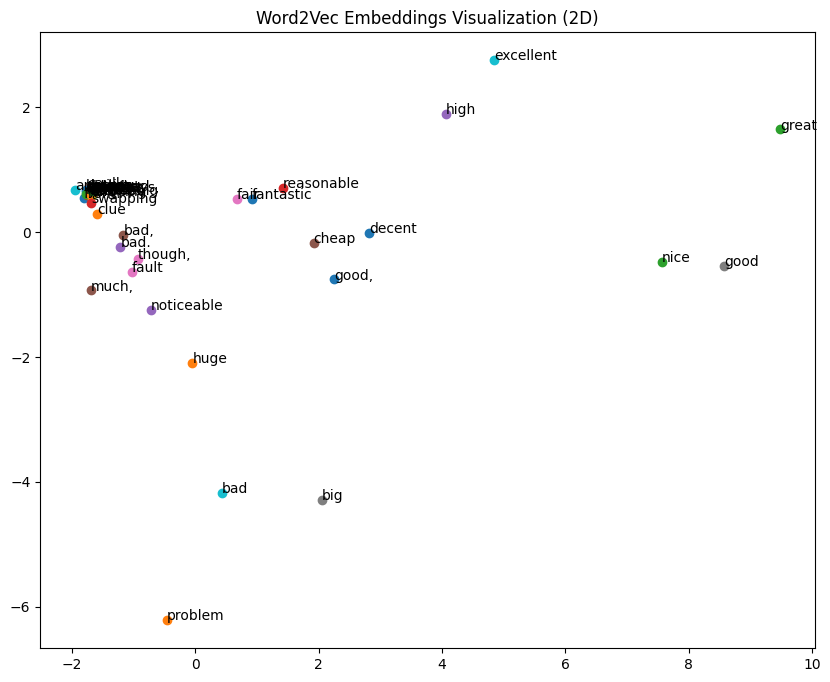

In [45]:
plt.figure(figsize=(10,8))

for i, word in enumerate(similar_words):
    plt.scatter(reduced[i,0], reduced[i,1])
    plt.annotate(word, (reduced[i,0], reduced[i,1]))

plt.title("Word2Vec Embeddings Visualization (2D)")
plt.show()

The 2D projection of Word2Vec embeddings shows that semantically related words tend to cluster together. Positive adjectives such as "great", "excellent", and "nice" appear in close proximity, while negative terms such as "bad" and "fault" are located in different regions of the space.

# Most Frequent N-grams

In [46]:
from nltk import ngrams, FreqDist

unigrams = ngrams(words, 1)
bigrams = ngrams(words, 2)
trigrams = ngrams(words, 3)

In [47]:
unigrams_freq = FreqDist(unigrams)
bigrams_freq = FreqDist(bigrams)
trigrams_freq = FreqDist(trigrams)

In [48]:
unigrams_freq.most_common(10)

[(('the',), 86825),
 (('and',), 47224),
 (('to',), 46695),
 (('a',), 43892),
 (('i',), 43188),
 (('it',), 34076),
 (('of',), 23509),
 (('is',), 23287),
 (('this',), 22115),
 (('for',), 19536)]

In [49]:
bigrams_freq.most_common(10)

[(('of', 'the'), 6094),
 (('on', 'the'), 4986),
 (('in', 'the'), 4933),
 (('i', 'have'), 4080),
 (('it', 'is'), 3444),
 (('to', 'the'), 3376),
 (('is', 'a'), 3231),
 (('this', 'is'), 3009),
 (('with', 'the'), 2898),
 (('and', 'the'), 2889)]

In [50]:
trigrams_freq.most_common(10)

[(('this', 'is', 'a'), 1030),
 (('a', 'lot', 'of'), 757),
 (('out', 'of', 'the'), 540),
 (('if', 'you', 'have'), 524),
 (('i', 'bought', 'this'), 517),
 (('i', 'have', 'a'), 500),
 (('one', 'of', 'the'), 447),
 (('i', 'had', 'to'), 440),
 (('it', 'is', 'a'), 429),
 (('this', 'is', 'the'), 426)]

Most of them are stopwords.

## Preprocessing

A text preprocessing function is defined to remove stopwords, eliminate symbols, and filter out all non-alphabetic characters. Since the text is in English, there is no need to handle accent marks.

In [51]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [52]:
import re

def sentence_normalization(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r"[^a-z\s]", "", sentence).strip() #Remove all non-alphabetic characters.
  return sentence

In [53]:
def remove_stopwords(sentence, sw_list):
  sentence = ' '.join([word for word in sentence.split() if word not in sw_list or word == 'no'])
  return sentence

In [54]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') #download the list of stopwor
sw_list = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [55]:
def process_reviews(reviews, sw_list):
    processed_sentences = []
    for sent in df['review']:
        if pd.notna(sent):  # check if sent is NaN
            sent = sentence_normalization(sent)
            sent = remove_stopwords(sent, sw_list)
            processed_sentences.append(sent)
        else:
            processed_sentences.append('None')
    return processed_sentences

In [56]:
processed_reviews = process_reviews(df['review'], sw_list)

In [57]:
processed_reviews[1]

'long cables work fine truck quality seems little shabby side money expecting dollar snapon jumper cables seem like would see chinese knock shop like harbor freight bucks'

In [58]:
print('Review original: {}'.format(df['review'].values[0]))
print('Review procesada: {}'.format(processed_reviews[0]))

Review original: I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though.
Review procesada: needed set jumper cables new car good reviews good price used times already supposed no complaints therewhat say feet really isnt ideal length sure pull front bumper front bumper plenty long lot times beside another car cant get really close would recommend something little longer great brand get version though


In [59]:
df.loc[:, 'processedReview'] = processed_reviews #For all rows in the DataFrame, create or replace the column processedReview and populate it with processed_reviews.

In [60]:
import numpy as np

df['processedReview'] = df['processedReview'].replace('', np.nan)
df = df.dropna(subset=['processedReview'])

# Modeling

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['processedReview'], df['sentiment_label'], train_size=0.75, test_size=0.25, random_state=42, shuffle=True,stratify=df['sentiment_label'])

In [62]:
X_train.iloc[:8]

,processedReview
12672,really keeps air vent camper trim bit fit good...
8415,purchased plug replace oild stock one found at...
8030,ive used trucks cars motorcycles tractors work...
13451,ive used different locations connectors rv doe...
1585,great wax truly deserves gold class name use m...
4412,yes isnt cheapest oil available expensive eith...
14786,bought utv side side much heavy beefier could ...
15776,please remember diluted using right bottle har...


In [63]:
y_train.iloc[:8]

,sentiment_label
12672,1
8415,1
8030,1
13451,1
1585,1
4412,1
14786,1
15776,1


In [64]:
print(sum(y_train))   #To ensure that the stratified split was performed correctly.
print(len(y_train))
print(sum(y_train)/len(y_train))

13131
14995
0.8756918972990997


In [65]:
print(sum(y_test))
print(len(y_test))
print(sum(y_test)/len(y_test))

4378
4999
0.8757751550310062


## Data augmentation

### Data Augmentation Strategy

In order to address the class imbalance present in the dataset, data augmentation was applied exclusively to the negative reviews. Since the number of negative samples was significantly lower than positive ones, the objective was to increase the diversity and representation of the minority class without collecting additional real data.

### Back Translation

Back translation was selected as the augmentation technique. This method consists of translating a sentence from the source language (English) to an intermediate language (Spanish), and then translating it back to English. The goal is to generate semantically equivalent sentences with slight lexical or syntactic variations.

This approach helps introduce linguistic variability while preserving the original sentiment label. Unlike simple synonym replacement, back translation often produces more natural and context-aware reformulations.

In [66]:
from transformers import MarianMTModel, MarianTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# English → Spanish
model_en_es_name = "Helsinki-NLP/opus-mt-en-es"
tokenizer_en_es = MarianTokenizer.from_pretrained(model_en_es_name)
model_en_es = MarianMTModel.from_pretrained(model_en_es_name).to(device)

# Spanish → English
model_es_en_name = "Helsinki-NLP/opus-mt-es-en"
tokenizer_es_en = MarianTokenizer.from_pretrained(model_es_en_name)
model_es_en = MarianMTModel.from_pretrained(model_es_en_name).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [67]:
def back_translate(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return text

    # EN → ES
    inputs = tokenizer_en_es(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        translated = model_en_es.generate(**inputs)

    spanish_text = tokenizer_en_es.decode(
        translated[0],
        skip_special_tokens=True
    )

    # ES → EN
    inputs_back = tokenizer_es_en(
        spanish_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        translated_back = model_es_en.generate(**inputs_back)

    english_text = tokenizer_es_en.decode(
        translated_back[0],
        skip_special_tokens=True
    )

    return english_text

In [68]:
train_df = pd.DataFrame({
    "review": X_train,
    "label": y_train
})

In [69]:
negative_df = train_df[train_df["label"] <= 2]

In [70]:
len(negative_df)

14995

In [71]:
def back_translate_batch(texts, batch_size=32):
    augmented_texts = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # EN → ES
        inputs = tokenizer_en_es(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            translated = model_en_es.generate(**inputs)

        spanish_texts = [
            tokenizer_en_es.decode(t, skip_special_tokens=True)
            for t in translated
        ]

        # ES → EN
        inputs_back = tokenizer_es_en(
            spanish_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            translated_back = model_es_en.generate(**inputs_back)

        english_texts = [
            tokenizer_es_en.decode(t, skip_special_tokens=True)
            for t in translated_back
        ]

        augmented_texts.extend(english_texts)

    return augmented_texts

In [72]:
print(device)

cuda


### Why Batch Processing Was Implemented

Initially, back translation was applied one sentence at a time. However, transformer models such as MarianMT are computationally expensive, since each translation requires a forward pass through the neural network.

Processing sentences individually results in long execution times and inefficient use of computational resources.

To improve efficiency, a batch-based function (back_translate_batch) was implemented. Instead of translating sentences one by one, multiple sentences are processed simultaneously in batches (e.g., batch_size=32).

Batch processing reduces the number of forward passes and better utilizes parallel computation (especially with GPU), making the augmentation process faster and more efficient.

In [73]:
negative_sample = negative_df.sample(n=2000, random_state=42)

negative_texts = negative_sample["review"].tolist()

augmented_texts = back_translate_batch(negative_texts, batch_size=32)

negative_sample["review"] = augmented_texts

### Why Only 2000 Samples Were Augmented

Although more negative samples were available, only 2000 were selected for augmentation (and it stills requires execution time of about 1 hour). Back translation is computationally expensive, and even when using a GPU, processing 5000 samples required a very long execution time.

To keep the process manageable and efficient, the number of augmented samples was reduced. This allowed experimentation with data augmentation without excessively increasing computational cost or processing time.

In [74]:
augmented_train_df = pd.concat([train_df, negative_sample])

In [75]:
X_train_aug = augmented_train_df["review"]
y_train_aug = augmented_train_df["label"]

In [76]:
X_train_original = train_df["review"]
y_train_original = train_df["label"]

In [77]:
test_sentence = "The movie was absolutely terrible and boring."

augmented = back_translate(test_sentence)

print("Original:", test_sentence)
print("Augmented:", augmented)

Original: The movie was absolutely terrible and boring.
Augmented: The film was absolutely terrible and boring.


# Feature Extraction

TfidfVectorizer tokenizes the text, builds a vocabulary from the training corpus, and represents each document as a vector where each term is weighted using TF (term frequency) and IDF (inverse document frequency), which penalizes terms that appear in many documents.

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(max_df=0.95, min_df=3, max_features=2500, ngram_range=(1,2))
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, ngram_range=(1, 2))

In [79]:
print(list(cv.vocabulary_.items())[:20])

[('really', np.int64(1711)), ('keeps', np.int64(1101)), ('air', np.int64(40)), ('vent', np.int64(2314)), ('camper', np.int64(272)), ('trim', np.int64(2235)), ('bit', np.int64(183)), ('fit', np.int64(762)), ('good', np.int64(877)), ('thick', np.int64(2153)), ('weather', np.int64(2372)), ('happy', np.int64(934)), ('purchase', np.int64(1659)), ('happy purchase', np.int64(935)), ('purchased', np.int64(1660)), ('plug', np.int64(1571)), ('replace', np.int64(1754)), ('stock', np.int64(2052)), ('one', np.int64(1453)), ('found', np.int64(801))]


In [80]:
print(len(cv.vocabulary_))

2500


From Raw Text to TF-IDF Matrix

In [81]:
X_train_original_ = cv.transform(X_train_original)
X_test_ = cv.transform(X_test)

In [82]:
X_train_aug_ = cv.transform(X_train_aug)

## Feature Analysis

## $\chi²$ scores


The $\chi^2$ (chi-squared) statistic is used to analyze the relationship between vocabulary terms and the target variable. It allows us to identify which words and n-grams are the most discriminative for sentiment analysis.

In [83]:
from sklearn.feature_selection import chi2

chi2_scores, p_values = chi2(X_train_original_, y_train)
feature_names = cv.get_feature_names_out()

top_pos = np.argsort(chi2_scores)[-10:]
top_neg = np.argsort(chi2_scores)[:10]

top_features = feature_names[top_pos]
top_features_neg = feature_names[top_neg]



In [84]:
top_features


array(['work better', 'maybe', 'would', 'great', 'useless', 'returned',
       'waste', 'return', 'waste money', 'ok'], dtype=object)

It can be observed that the dataset clearly contains sentiment-related signal. Therefore, using a bag-of-words representation is a reasonable approach.

In [85]:
top_features_neg

array(['situation', 'costs', 'gun', 'hilift', 'accord', 'traditional',
       'shiny', 'bolt', 'silverado', 'dont get'], dtype=object)

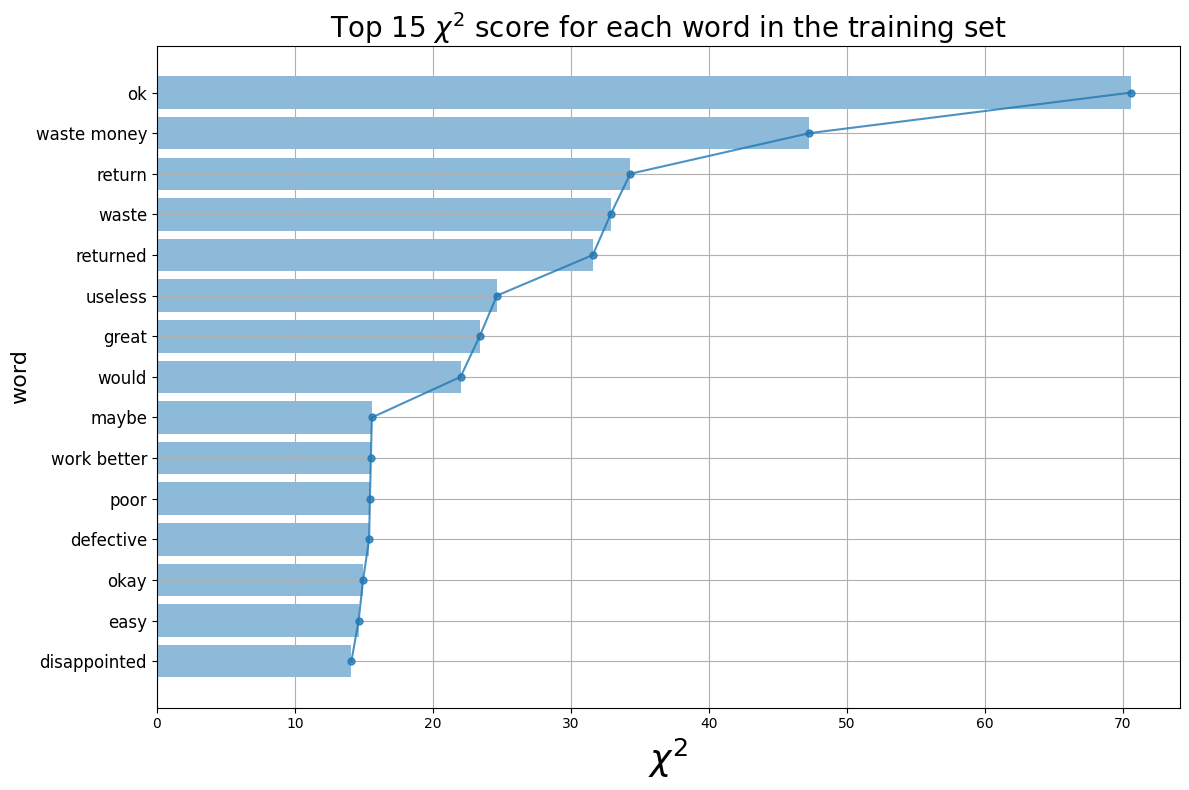

In [86]:
# Compute the chi-squared score for each word in the training set and show the values

import matplotlib.pyplot as plt

i = 15

chi2score = chi2(X_train_original_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel(r'$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title(r'Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

## Training a Classification Model - without data augmentation

Since the dataset is imbalanced, the parameter class_weight="balanced" is applied to compensate for class imbalance by assigning higher weights to the minority class.

In [87]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

svm = LinearSVC(class_weight="balanced", random_state=42)

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring="f1_macro",   # important since the dataset is not balanced
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train_original_, y_train)




GridSearchCV(cv=5,
             estimator=LinearSVC(class_weight='balanced', random_state=42),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='f1_macro')

In [88]:
grid.best_params_


{'C': 0.1}

In [89]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results[[
    "param_C",
    "mean_train_score",
    "mean_test_score"
]]


,param_C,mean_train_score,mean_test_score
0,0.01,0.692571,0.653313
1,0.10,0.764894,0.673536
2,1.00,0.823607,0.662011
3,10.00,0.869355,0.638541
4,100.00,0.909022,0.624582


In [90]:
best_model = grid.best_estimator_

In [91]:
import numpy as np
from sklearn.metrics import precision_score

scores_train = best_model.decision_function(X_train_original_)  # 1D
thresholds = np.linspace(scores_train.min(), scores_train.max(), 200)

best_t = None
best_prec0 = -1

for t in thresholds:
    y_train_pred = (scores_train < t).astype(int)
    prec0 = precision_score(y_train, y_train_pred, pos_label=0)

    if prec0 > best_prec0:
        best_prec0 = prec0
        best_t = t

print("Best threshold (decision_function):", best_t)
print("Precision class 0 (train):", best_prec0)


Best threshold (decision_function): -2.017500794866963
Precision class 0 (train): 0.1243081027009003


In [92]:
print(np.unique(best_model.predict(X_train_original_), return_counts=True))
print(np.corrcoef((scores_train > 0).astype(int), best_model.predict(X_train_original_))[0,1])


(array([0, 1]), array([ 3729, 11266]))
1.0


In [93]:
y_pred = (scores_train > t).astype(int)


In [94]:
y_test_predict = best_model.predict(X_test_)

In [95]:

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, y_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_test_predict)))

Confusion matrix:
[[ 439  182]
 [ 788 3590]]

Classification report:
              precision    recall  f1-score   support

           0       0.36      0.71      0.48       621
           1       0.95      0.82      0.88      4378

    accuracy                           0.81      4999
   macro avg       0.65      0.76      0.68      4999
weighted avg       0.88      0.81      0.83      4999

Accuracy score:0.8059611922384476


The model is performing poorly when predicting negative reviews. The precision for class 0 is very low because the model predicts too many 0s when the true label should be 1, resulting in a high number of false positives for class 0.

Note: Two adjustments were made:

In the TF-IDF feature extractor, the n-gram range was initially set to (1,3). However, trigrams appeared to introduce additional noise, so the range was reduced to (1,2).

Regarding the optimization metric, the scoring parameter was initially set to "f1". It was later changed to "f1_macro" to ensure that the model gives equal importance to both classes, particularly the minority class (class 0).

In [96]:
y_test_predict = best_model.predict(X_test_)

In [97]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_test_predict)

In [98]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

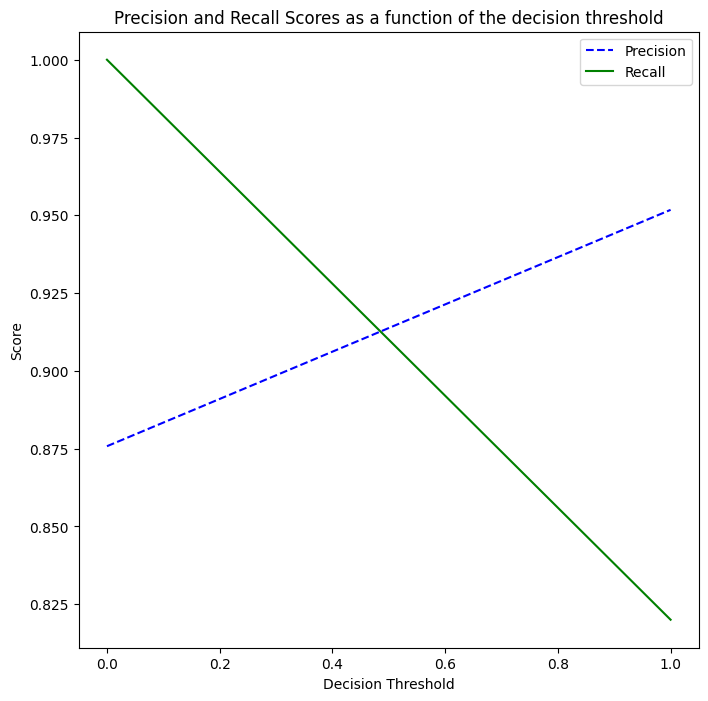

In [99]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

Depending on the prediction objective, different improvement strategies may be appropriate. If the main goal is to increase the precision of class 0, the decision threshold should be adjusted to favor fewer class 0 predictions (i.e., only predict class 0 when the model is highly confident). However, if the goal is to improve the recall of class 0, the threshold should be adjusted in the opposite direction, accepting more class 0 predictions at the cost of lower precision.

## Predict without data augmentation

In [100]:
def predict_review_sentiment(review_index, model):
  print('actual sentiment: {}'.format(df.loc[review_index]['sentiment_label']))
  review = df.iloc[review_index]['review']
  print('prediction: {}'.format(model.predict(cv.transform([review]))))

In [101]:
import random
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, best_model)


Review no. 10605
actual sentiment: 1
prediction: [1]

Review no. 6620
actual sentiment: 1
prediction: [1]

Review no. 3632
actual sentiment: 1
prediction: [1]

Review no. 7929
actual sentiment: 1
prediction: [1]

Review no. 18349
actual sentiment: 1
prediction: [1]


## Model training and evaluation with data augmentation

In [102]:
grid.fit(X_train_aug_, y_train_aug)

GridSearchCV(cv=5,
             estimator=LinearSVC(class_weight='balanced', random_state=42),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='f1_macro')

In [110]:
print(len(X_train))
print(len(X_train_aug))

14995
16995


In [103]:
grid.best_params_

{'C': 0.1}

In [104]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
results[[
    "param_C",
    "mean_train_score",
    "mean_test_score"
]]


,param_C,mean_train_score,mean_test_score
0,0.01,0.695373,0.660544
1,0.10,0.765537,0.684717
2,1.00,0.818490,0.675822
3,10.00,0.857408,0.662357
4,100.00,0.882358,0.650836


In [122]:
best_model_aug = grid.best_estimator_

In [126]:
y_pred_aug = best_model_aug.predict(X_test_)

In [127]:
import numpy as np
from sklearn.metrics import precision_score

scores_train = best_model_aug.decision_function(X_train_aug_)  # 1D
thresholds = np.linspace(scores_train.min(), scores_train.max(), 200)

best_t = None
best_prec0 = -1

for t in thresholds:
    y_train_pred = (scores_train < t).astype(int)
    prec0 = precision_score(y_train_aug, y_train_pred, pos_label=0)

    if prec0 > best_prec0:
        best_prec0 = prec0
        best_t = t

print("Best threshold (decision_function):", best_t)
print("Precision class 0 (train):", best_prec0)

Best threshold (decision_function): -2.16861421578224
Precision class 0 (train): 0.12568402471315093


In [129]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, y_pred_aug)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_pred_aug)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_aug)))

Confusion matrix:
[[ 444  177]
 [ 780 3598]]

Classification report:
              precision    recall  f1-score   support

           0       0.36      0.71      0.48       621
           1       0.95      0.82      0.88      4378

    accuracy                           0.81      4999
   macro avg       0.66      0.77      0.68      4999
weighted avg       0.88      0.81      0.83      4999

Accuracy score:0.8085617123424685


# Predict with data augmentation


In [108]:
def predict_review_sentiment(review_index, model):
  print('actual sentiment: {}'.format(df.loc[review_index]['sentiment_label']))
  review = df.iloc[review_index]['review']
  print('prediction: {}'.format(model.predict(cv.transform([review]))))


In [114]:
import random
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, best_model_aug)


Review no. 16211
actual sentiment: 1
prediction: [0]

Review no. 16981
actual sentiment: 0
prediction: [1]

Review no. 1384
actual sentiment: 1
prediction: [0]

Review no. 4817
actual sentiment: 1
prediction: [1]

Review no. 6686
actual sentiment: 1
prediction: [1]


## Conclusion

In this dataset, training was performed using a TF-IDF vectorizer followed by an SVM classifier. The model was evaluated both with and without data augmentation. Augmentation was applied exclusively to negative comments, as the dataset is highly imbalanced.

From the experimental results, data augmentation does not appear to provide meaningful benefits in this case. Although back-translation was implemented with batch processing to improve efficiency, it remained computationally expensive, even when applied to only 2000 negative samples.

A comparison of the confusion matrices and classification reports before and after augmentation shows nearly identical performance. Accuracy, macro F1-score, and minority class metrics (precision, recall, and F1-score) remained essentially unchanged. This indicates that the slight variation observed during cross-validation did not translate into a measurable improvement in final model performance.

In particular, the discriminative performance for the minority class did not improve. Precision and recall for class 0 remained stable, suggesting that the augmented samples did not introduce additional informative patterns that the TF-IDF + SVM model could effectively leverage.

These findings suggest that, for classical machine learning models based on bag-of-words representations, back-translation may add computational cost without substantially enhancing minority class detection. The contextual variability introduced by paraphrasing is not fully captured by TF-IDF features, limiting the practical impact of this augmentation strategy.

Note: Since this dataset is highly imbalanced and data augmentation with negative comments did not lead to significant improvement, I decided to conduct further analysis using a different dataset (the Baby Products dataset in the other notebook)